# Computer Assignment 4 a) -- Group 2
* Ali Bemani
* Oscar Bautista Gonzalez
* Martin Hellkvist

This document is structured like this:
* Problem setup
    * Describes the problem setup, cost functions and gradients
    * Preprocessing of data
    * Robustifications
* Summary of Results
* Implementation
The results and implementations for 4b) and c) is included in a separate file ``CA-G2-4-bc.ipynb``.

# Problem setup
The MNIST dataset is used to train a binary SVM classifier.
The dataset is restricted to only examples with labels "0" and "1", this way we only have two classes, and can use a binary SVM classifier.
The multiclass SVM classifier is an extension to this, but we ignore it for the sake of simplicity.

We transform the labels so that "0" is assigned -1, and "1" is assigned +1.
This enables us to define the objective function as
$$ L(w) = \frac{1}{N} \sum_{i\in [N]} L_i(w) + \lambda ||w||_2^2, $$
$$ L_i(w) = \max(0, 1 - y_i w^T x_i) $$
and we use the following subgradient for gradient descent:
$$ \partial L_i(w) = -y_i x_i, ~~\text{if}~~ 1 - y_i w^T x_i > 0,~~ \text{otherwise} ~~ \partial L_i(w) = 0 $$
so that the subgradient for $L$ becomes
$$ \partial L(w) = \frac{1}{N} \sum_{i\in[N]} \partial L_i(w) + 2\lambda w $$

## Preprocessing of data
After removing the examples with labels not "0" or "1" we do some preprocessing of the data.
Originally each example has the label together with an 28 by 28 array of pixels with values from 1 to 255.
We reorganize it so that each of these arrays is a $28^2=784$ vector scaled by $1/255$.
This scaling rescales the problem, and can give nicer numerical properties.
Then we append a new entry into each vector of value $1$, which enables the transformation $w^T x_i$ to be affine, rather than strictly linear.

## Distribution over workers
We then split the input data into a python list ``X`` with 10 elements.
Each element is a numpy array of shape ``(N,785)``, where ``N`` is the number of data used for training in each worker.
We also have the list ``Y`` which is also of 10 elements, but with numpy arrays of shape ``(N,1)``.

## Computation of gradients
The (sub)gradients are then computed in a distributed fashion like this
* For each worker ``i = 1, ..., 10``
    * ``g[i] = compute_gradient(w, X[i], Y[i])``
    * ``with probablitiy p, add a sample of white Gaussian noise with variance R to g[i]``
    
Then the parameters at the master is computed like ``w = g[1] + ... + g[10]``.

## Robustification
Due to time limitations, we are yet to implement a robustification against the noise, but here provide the idea that we will implement later on.

We introduce some memory cell,
which remembers the K latest average gradients and averages over these for the gradient descent step.
So it becomes a sliding average.
Because the noise is zero mean, we expect it to cancel out over time.

# Summary of results
The algorithm works quite nicely, and tuning step size and regularization is rather straight forward, the procedure would be something like setting $\lambda=0$ and then trying stepsizes like 0.001, 0.01, 0.1, 1, etc. and trianguling in a good value. Then one can tune the regularization in a similar fashion.

We found that a higher noise variance $R$ or probability $p$ increases the cost level to which the algorithm converges to, and thus the final accuracy (correct prediction percentage) the algorithm can achieve.

Averaging over 100 simulations of noise sequences gave this quite clear conclusion.

Plots to visualize this is saved in the end of the notebook, but you should also be able to run the notebook as is, and obtain them.

In [78]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [79]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0 for easier life

In [80]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

1.0


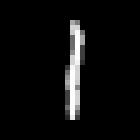

In [81]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

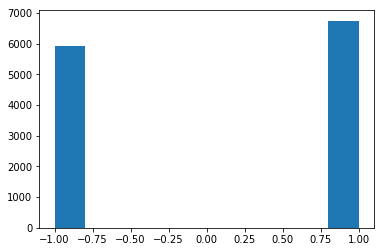

In [82]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

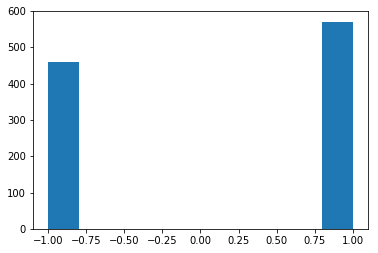

In [83]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [84]:
np.random.seed(0)
N_train = 600
N_data = test_data.shape[0]
N_workers = 10
indexes_ = np.random.choice(N_data, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

In [85]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Gradient Solvers
The local function in worker $i$ to minimize is

$$ f_i(w) = \frac{1}{|D_i|} \sum_{(x,y)\in D_i} (y - w^T x)^2 $$

which has the gradient 

$$ \nabla f_i(w) =  \frac{2}{|D_i|} \sum_{(x,y)\in D_i} x (w^T x - y)  $$

### Compute Grad

In [86]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [87]:
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1 - Y * (X @ w) # (N,1)
    L[L < 0] = 0
    return L

### Cost

In [88]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [89]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [90]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Def solver

In [91]:
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD",
           mini_batch = 100, mem=False, return_cost=False, verbose=True, seed=-1, p_val=0, R_val=0):
    
    N_workers = len(X)
    dw = w.shape[0]
    
    noise_std = R_val**0.5
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
    if return_cost:
        cost_[0] = cost(w, X_test, Y_test)
    
    if (optimizer == "GD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            for worker_i in range(N_workers):
#                 set_trace()
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_) \
                        + np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g/N_workers # GD update
                
            if return_cost:
                cost_[i+1] = cost(w, X[0], Y[0])
                
        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
            
    if return_cost:
        return cost_, w

# Run SVM solver on data

GD: Number of iterations:  1000 / 1000
GD: final norm:  24.822416519635766
Runtime GD num_iters= 2.4145429134368896
final cost 0.0
final acc: 0.9932104752667313


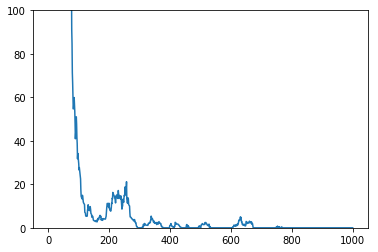

In [92]:
d = X[0].shape[1]
w = np.random.rand(d,1)
alpha = 0.03
num_iters = 1000
lambda_ = 0
epsilon = 0
p_val = .1
R_val = 1
time1 = time.time()
cost_GD, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                 mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val)
time2 = time.time()
print("Runtime GD num_iters=", time2-time1)

plt.plot(cost_GD)
print("final cost", cost_GD[-1])
plt.ylim(0,100)

acc_final = accuracy(w_out, X_test, y_test)
print("final acc:", acc_final)

## grid over noise variance

In [93]:
d = X[0].shape[1]
w = np.random.rand(d,1)
alpha = 0.03
num_iters = 1000
lambda_ = .01
epsilon = 0

r_vector = [0.25, .75, 1.5, 2.5]
p_val = 0.5

cost_GD_R = [np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1)]
N_seeds = 100
for seed in range(N_seeds):
    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[0]**2)
    cost_GD_R[0] += cost_/N_seeds
    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[1]**2)
    cost_GD_R[1] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[2]**2)
    cost_GD_R[2] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_val, R_val=r_vector[3]**2)
    cost_GD_R[3] += cost_/N_seeds
    
    print(".....", seed, ".....")

..... 0 .....
..... 1 .....
..... 2 .....
..... 3 .....
..... 4 .....
..... 5 .....
..... 6 .....
..... 7 .....
..... 8 .....
..... 9 .....
..... 10 .....
..... 11 .....
..... 12 .....
..... 13 .....
..... 14 .....
..... 15 .....
..... 16 .....
..... 17 .....
..... 18 .....
..... 19 .....
..... 20 .....
..... 21 .....
..... 22 .....
..... 23 .....
..... 24 .....
..... 25 .....
..... 26 .....
..... 27 .....
..... 28 .....
..... 29 .....
..... 30 .....
..... 31 .....
..... 32 .....
..... 33 .....
..... 34 .....
..... 35 .....
..... 36 .....
..... 37 .....
..... 38 .....
..... 39 .....
..... 40 .....
..... 41 .....
..... 42 .....
..... 43 .....
..... 44 .....
..... 45 .....
..... 46 .....
..... 47 .....
..... 48 .....
..... 49 .....
..... 50 .....
..... 51 .....
..... 52 .....
..... 53 .....
..... 54 .....
..... 55 .....
..... 56 .....
..... 57 .....
..... 58 .....
..... 59 .....
..... 60 .....
..... 61 .....
..... 62 .....
..... 63 .....
..... 64 .....
..... 65 .....
..... 66 .....
.....

## Grid over p_val

In [94]:
d = X[0].shape[1]
w = np.random.rand(d,1)
alpha = 0.03
num_iters = 1000
lambda_ = 0.01
epsilon = 0

r_val = .75
p_vector = [0.1, 0.25, 0.5, 1]

cost_GD_p = [np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1),np.zeros(num_iters+1)]
N_seeds = 100
for seed in range(N_seeds):
    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[0], R_val=r_val**2)
    cost_GD_p[0] += cost_/N_seeds
    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[1], R_val=r_val**2)
    cost_GD_p[1] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[2], R_val=r_val**2)
    cost_GD_p[2] += cost_/N_seeds

    cost_, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                     mem=False, return_cost=True, verbose=False, seed=seed, p_val=p_vector[3], R_val=r_val**2)
    cost_GD_p[3] += cost_/N_seeds
    
    print(".....", seed, ".....")

..... 0 .....
..... 1 .....
..... 2 .....
..... 3 .....
..... 4 .....
..... 5 .....
..... 6 .....
..... 7 .....
..... 8 .....
..... 9 .....
..... 10 .....
..... 11 .....
..... 12 .....
..... 13 .....
..... 14 .....
..... 15 .....
..... 16 .....
..... 17 .....
..... 18 .....
..... 19 .....
..... 20 .....
..... 21 .....
..... 22 .....
..... 23 .....
..... 24 .....
..... 25 .....
..... 26 .....
..... 27 .....
..... 28 .....
..... 29 .....
..... 30 .....
..... 31 .....
..... 32 .....
..... 33 .....
..... 34 .....
..... 35 .....
..... 36 .....
..... 37 .....
..... 38 .....
..... 39 .....
..... 40 .....
..... 41 .....
..... 42 .....
..... 43 .....
..... 44 .....
..... 45 .....
..... 46 .....
..... 47 .....
..... 48 .....
..... 49 .....
..... 50 .....
..... 51 .....
..... 52 .....
..... 53 .....
..... 54 .....
..... 55 .....
..... 56 .....
..... 57 .....
..... 58 .....
..... 59 .....
..... 60 .....
..... 61 .....
..... 62 .....
..... 63 .....
..... 64 .....
..... 65 .....
..... 66 .....
.....

## Plot

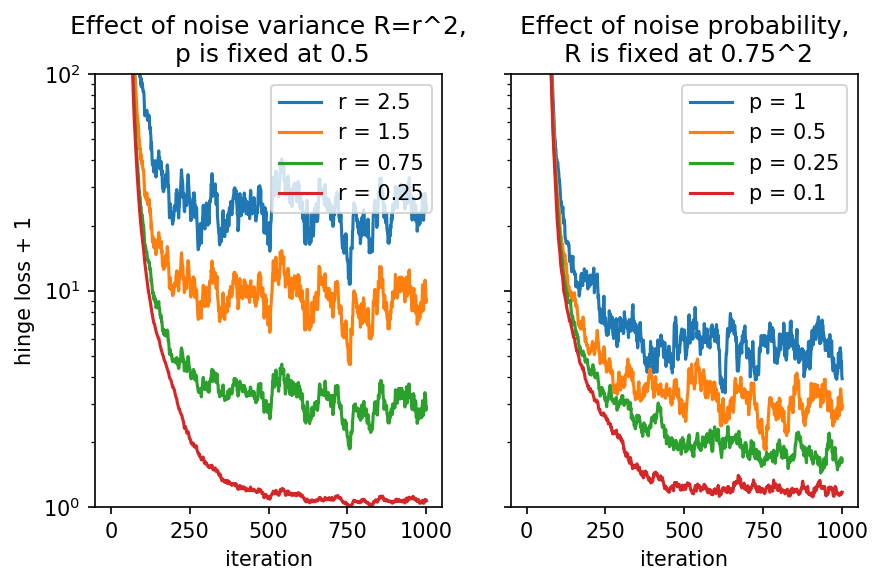

In [95]:
dpi = 150
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, dpi=dpi)
for i in reversed(range(4)):
    ax2.plot(cost_GD_p[i]+1, label=("p = " + str(p_vector[i])))
ax2.legend(loc='best')
ax2.set_ylim(1,100)
# ax2.set_xlim(0,500)
ax2.set_yscale('log')
ax2.set_title("Effect of noise probability,\n R is fixed at 0.75^2")
ax2.set_xlabel("iteration")

# plt.subplot(2,2,1,dpi=dpi)
for i in reversed(range(4)):
    ax1.plot(cost_GD_R[i]+1, label=("r = " + str(r_vector[i])))
ax1.legend(loc='best')
ax1.set_ylim(1,100)
# ax1.set_xlim(0,500)
ax1.set_yscale('log')
ax1.set_title("Effect of noise variance R=r^2,\n p is fixed at 0.5")
ax1.set_ylabel("hinge loss + 1")
ax1.set_xlabel("iteration")
plt.tight_layout()